# Inferring Velocities By Minimizing the Line Width

This Notebook intends to demonstrate the method used in [Teague et al. (2018a)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...860L..12T) to infer the rotation velocity as a function of radius in the disk of HD 163296. The following [Notebook](fitannulus_2.ipynb) demonstrates the updated method presented in [Teague et al. (2018b)](https://ui.adsabs.harvard.edu/abs/2018ApJ...868..113T/abstract) which relaxes many of the assumptions used in this Notebook.

## Methodology

For this method to work we make the assumption that the disk is azimuthally symmetric (note that this does not mean that the emission we observe in symmetric, but only that the underlying disk structure is). Therefore, if we were to observe the line profile at different azimuthal angles for a given radius, they should all have the same shape. What will be different is the line centre due to the line-of-sight component of the rotation,

$$v_0 = v_{\rm LSR} + v_{\phi} \cdot \cos \phi$$ 

where $i$ is the inclination of the disk, $\phi$ is the azimuthal angle measured from the red-shifted major axis and $v_{\rm LSR}$ is the systemic velocity. Note that this azimuthal angle is not the same as position angle and must be calculated accounting for the 3D structure of the disk.

It has already been shown by assuming a rotation velocity, for example from fitting a first moment map, each spectrum can be shifted back to the systemic velocity and then stacked in azimuth to boost the signal-to-noise of these lines (see [Yen et al., 2016](https://ui.adsabs.harvard.edu/#abs/2016ApJ...832..204Y) for a thorough discussion on this and [Teague et al., 2016](https://ui.adsabs.harvard.edu/#abs/2016A&A...592A..49T) and [Matrà et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...842....9M) for applications of this).

---

![Example of shifted spectra.](../_static/first_moment_and_spectra.png)

In the above image, the left hand plot shows the typical Keplerian rotation pattern, taking into account a flared emission surface. Dotted lines show contours of constant azimuthal angle $\theta$ and radius $r$. Three spectra, shown on the right in black, are extracted at the dot locations. By shifting the velocity axis of each of this by $-v_{\phi} \cdot \cos \phi$ they are aligned along the systemic velocity, $v_{\rm LSR}$, and able to be stacked (shown in gray).

---

However, this only works correctly if we know the rotation velocity. If an incorrect velocity is used to deproject the spectra then the line centres will be scattered around the systemic velocity. When these lines are stacked, the resulting profile will be broader with a smaller amplitude. We can therefore assert that the correct velocity used to derproject the spectra is the one which _minimises the width of the stacked line profile_. One could make a similar argument about the line peak, however with noisy data this is a less strict constraint as this relies on one channel (the one containing the line peak) rather than the entire line profile ([Yen et al. (2018)](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..204Y/abstract), who use a similar method, use the signal-to-noise of the stacked line weighted by a Gaussian fit as their quality of fit measure, which can be accessed through the `annulus.get_vlos()` function).

## Python Implementation

This approach is relatively simple to code up with Python. We consider the case of very high signal-to-noise data, however it also works well with low signal-to-noise data, as we describe below. All the functions are part of the `eddy.fit_annulus.annulus` class which will be discussed in more detail below.

We start with an annulus of spectra which we have extracted from our data, along with their azimuthal angles and the velocity axis of the observations. We can generate model spectra through the `eddy.modelling` functions. We model an annulus of 20 independent spectra with a peak brightness temperature of 40K, a linewidth of 350m/s and and RMS noise of 2K. What's returned is an `ensemble` instance which containts all the deprojecting functions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from eddy.fit_annulus import annulus
from eddy.modelling import gaussian_ensemble

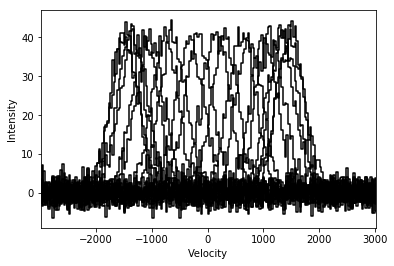

In [2]:
ensemble = gaussian_ensemble(vrot=1500., Tb=40., dV=350., rms=2.0, N=20, plot=True, return_annulus=True)

We first want to shift all the points to the systemic velocity (here at 0m/s). To do this we use the `deproject_spectrum()` function which takes the rotation as its main argument. It returns the new velocity of each pixel in the annulus and it's value. Lets first deproject with the correct rotation velocity of 1500m/s to check we recover the intrinsic line profile.

In [3]:
# Get the deprojected spectrum.
velocity, brightness = ensemble.deprojected_spectrum(1500.)

Text(0,0.5,'Intensity')

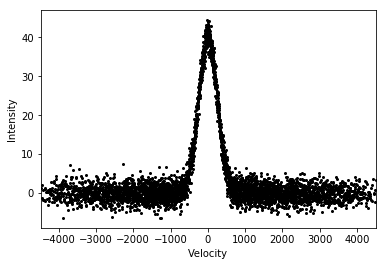

In [4]:
# Plot it.
fig, ax = plt.subplots()
ax.errorbar(velocity, brightness, fmt='.k', ms=4)
ax.set_xlim(velocity[0], velocity[-1])
ax.set_xlabel(r'Velocity')
ax.set_ylabel(r'Intensity')

This highlights which this method can achieve such a high precision on determinations of the rotation velocity. Because we shift back all the spectra by a non-quantised amount, we end up sampling the intrinsic profile at a much higher rate (by a factor of the number of beams we have in our annulus).

We can compare this with the spectrum which is resampled backed down to the original velocity resolution using the `deprojected_spectrum()` function with the `resample=True` argument.

Text(0,0.5,'Intensity')

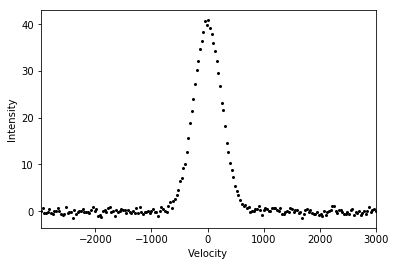

In [5]:
fig, ax = plt.subplots()
velocity, brightness = ensemble.deprojected_spectrum(1500., resample=True)
ax.errorbar(velocity, brightness, fmt='.k', ms=4)
ax.set_xlim(velocity[0], velocity[-1])
ax.set_xlabel(r'Velocity')
ax.set_ylabel(r'Intensity')

Note that we can also resample down to a higher sampling rate than the original data. Using `resample=N`, where `N` is an integer greater than 1, will increase the velocity sampling rate by a factor of `N`. Alternatively, a `float` value will give the spacing of the points, for example `resample=40.0` will return a spectrum sampled at 40m/s.

Text(0,0.5,'Intensity (+ Offset)')

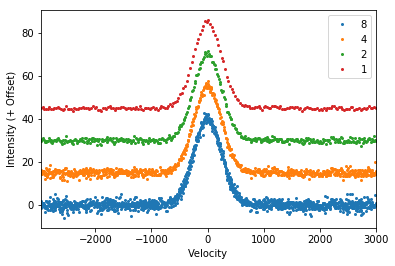

In [6]:
fig, ax = plt.subplots()
for n, N in enumerate([8, 4, 2, 1]):
    velocity, brightness = ensemble.deprojected_spectrum(1500., resample=N)
    ax.errorbar(velocity, n * 15 + brightness, fmt='.', ms=4, label=N)
ax.legend()
ax.set_xlim(velocity[0], velocity[-1])
ax.set_xlabel(r'Velocity')
ax.set_ylabel(r'Intensity (+ Offset)')

Now, if we projected the spectra with the incorrect velocity, we can see that the stacked spectrum becomes broader. Note also that this is symmetric about the correct velocity meaning this is a convex problem making minimization much easier.

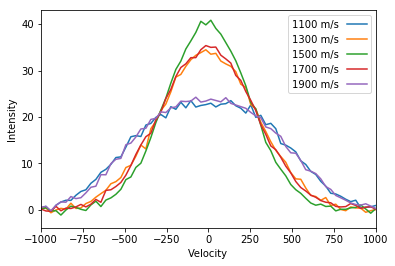

In [7]:
import numpy as np

fig, ax = plt.subplots()

for vrot in np.arange(1100, 2100, 200):
    velocity, brightness = ensemble.deprojected_spectrum(vrot, resample=True)
    ax.plot(velocity, brightness, label='%d m/s' % vrot)
    ax.legend(markerfirst=False)
    ax.set_xlim(-1000, 1000)
    ax.set_xlabel(r'Velocity')
    ax.set_ylabel(r'Intensity')

We can measure the width of the stacked lines by fitting a Gaussian using the `get_deprojected_width()` function.

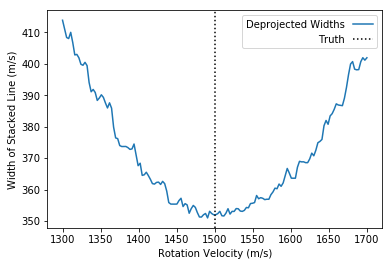

In [9]:
vrots = np.linspace(1300, 1700, 150)
widths = np.array([ensemble.deprojected_width(vrot, resample=True) for vrot in vrots])

fig, ax = plt.subplots()
ax.plot(vrots, widths, label='Deprojected Widths')
ax.axvline(1500., ls=':', color='k', label='Truth')
ax.set_xlabel(r'Rotation Velocity (m/s)')
ax.set_ylabel(r'Width of Stacked Line (m/s)')
ax.legend(markerfirst=False)

This shows that if we find the rotation velocity which minimizes the width of the stacked line we should have a pretty good idea of the rotation velocity is. The `get_vrot_dV()` function packges this all up, using the `bounded` method to search for the minimum width within a range of 0.7 to 1.3 times an initial guess. This guess can be provided (for instance if you have an idea of what the Keplerian rotation should be), otherwise it will try to guess it from the spectra based on the peaks of the spectra which are most shifted.

In [10]:
vfit = ensemble.get_vlos(fit_method='dV', fit_vrad=False)
print("The linewidth is minimized for a rotation velocity of {:.2f} m/s".format(vfit[0]))

The linewidth is minimized for a rotation velocity of 1505.90 m/s


The power of this method is also that the fitting is performed on the stacked spectrum meaning that in the noisy regions at the edges of the disk we stack over so many independent beams that we still get a reasonable line profile to fit.

Lets try with a signal-to-noise ratio of 4.

The linewidth is minimized for a rotation velocity of 1498.0 m/s


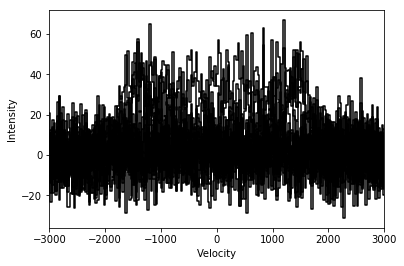

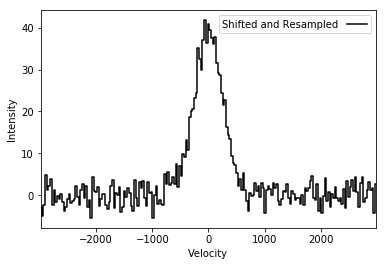

In [11]:
ensemble = gaussian_ensemble(vrot=1500., Tb=40., dV=350., rms=10.0, N=20, plot=True, return_annulus=True)

fig, ax = plt.subplots()
velocity, brightness = ensemble.deprojected_spectrum(1500., resample=True)
ax.step(velocity, brightness, color='k', where='mid', label='Shifted and Resampled')
ax.legend(markerfirst=False)
ax.set_xlim(velocity[0], velocity[-1])
ax.set_xlabel(r'Velocity')
ax.set_ylabel(r'Intensity')

vfit = ensemble.get_vlos(fit_method='dV', resample=True)
print("The linewidth is minimized for a rotation velocity of {:.1f} m/s".format(vfit[0]))

The final advtange of this method is that it is exceptionally quick. The convex nature of the problem means that a minimum width is readily found and so it can be applied very quickly, even with a large number of spectra. With 200 indiviudal beams:

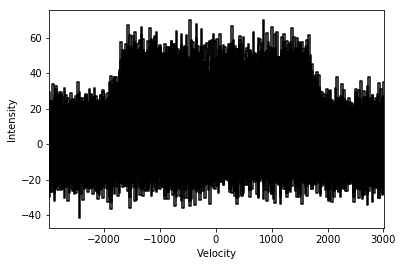

In [12]:
ensemble = gaussian_ensemble(vrot=1500., Tb=40., dV=350., rms=10.0, N=200, plot=True, return_annulus=True)

In [13]:
%timeit ensemble.get_vlos(fit_method='dV', resample=False)

1.31 s ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit ensemble.get_vlos(fit_method='dV', resample=True)

28.4 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This method, however, does not provide a good measure of the uncertainty on the inferred rotation velocity. Furthermore, it makes the implicit assumption that the intrinsic line profile is Gaussian which for optically thick lines is not the case. In the next [Notebook](fitannulus_2.ipynb) we use Gaussian Processes to model the stacked line profile and search for the smoothest model.